# Linear Regression Assignment
## Bike Sharing Assignment using Multiple Linear Regression

**Problem Statement :**

BoomBikes, a US bike-sharing provider, has experienced a significant drop in revenues due to the COVID-19 pandemic and is struggling to remain viable. To address this challenge, the company aims to develop a strategic business plan to boost revenue once the lockdown ends and the economy recovers. To prepare for the post-pandemic surge in bike demand, BoomBikes has hired a consulting firm to analyze the factors influencing demand for shared bikes in the American market.

The aim is to understand

- Which variables are significant in predicting the demand for shared bikes.-  How well those variables describe the bike demnds.s

In [727]:
# Importing  Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

#### *1.Data Understanding and Preparation*

In [729]:
# Reading dataset
data_df = pd.read_csv('day.csv')
data_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [730]:
#check for if any NULL or NA data in the dataset
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


##### features **instant** and **dteday** can be dropped since instant provides info of the serial number and dteday is already explained by other columns/features ie yr , mnth , weekday

In [732]:
data_df = data_df.drop(['instant','dteday'],axis =1)

#### *One-Hot Encoding Process - Categorical Variables*

#### *Creation of dummy variables for season and encoding its values ie season (1:spring, 2:summer, 3:fall, 4:winter)*

In [735]:
season_dummy= pd.get_dummies(data_df['season'],dtype='int')
season_dummy.head()
#season_dummy.info()

# Maping the dummy variables according to its enumerations
season_dummy=season_dummy.rename(columns={1:'spring',2:'summer',3:'fall',4:'winter'},inplace=False)
season_dummy.sample(5)

,spring,summer,fall,winter
372,1,0,0,0
480,0,1,0,0
697,0,0,0,1
13,1,0,0,0
108,0,1,0,0


##### *We don't need all four columns; we can drop one because each column can be inferred from the remaining three. For example, if we drop the 'spring' column, we can interpret the remaining columns as follows:*
* **000** corresponds to **spring**
* **100** corresponds to **summer**
* **010** corresponds to **fall**
* **001** corresponds to **winter**

In [737]:
data_df=pd.concat((data_df,season_dummy),axis=1)
data_df = data_df.drop(['season','spring'],axis=1)
data_df.sample(5)

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,summer,fall,winter
609,1,9,0,0,0,2,28.563347,32.45000,81.5000,4.292744,2613,3197,5810,0,1,0
378,1,1,0,6,0,1,7.380000,9.15435,45.7500,12.541261,333,2160,2493,0,0,0
333,0,11,0,3,1,1,13.325000,15.56105,61.3333,18.167586,188,3425,3613,0,0,1
452,1,3,0,4,1,1,20.260847,24.11520,43.9167,21.416550,834,5299,6133,1,0,0
283,0,10,0,2,1,2,23.233347,27.30480,80.8750,9.583814,667,3896,4563,0,0,1


##### *Similarly One-Hot encoding process is to be done for **mnth** , **weekday** , **weathersit** and its dummy creation can be done for its enumerated values*

In [739]:
for col in ['mnth','weekday','weathersit']:
    dummy=pd.get_dummies(data_df[col],dtype='int')
    if col == 'mnth':
        encoding_data={1:'Jan',2:'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
    elif col == 'weekday':
        encoding_data={0:'Sun',1:'Mon',2:'Tues',3:'Wed',4:'Thurs',5:'Fri',6:'Sat'}
    elif col == 'weathersit':
        encoding_data={1:'Clear',2:'Mist',3:'Light_Snow',4:'Heavy_Rain'}
        
    # Maping the dummy variables according to its enumerations
    dummy=dummy.rename(columns=encoding_data,inplace=False)
    data_df=pd.concat((data_df,dummy),axis=1)
    print(dummy)


data_df = data_df.drop(['mnth','Jan','weekday','Sun','weathersit','Clear'],axis=1)
data_df.sample(5)


     Jan  Feb  March  April  May  June  July  Aug  Sept  Oct  Nov  Dec
0      1    0      0      0    0     0     0    0     0    0    0    0
1      1    0      0      0    0     0     0    0     0    0    0    0
2      1    0      0      0    0     0     0    0     0    0    0    0
3      1    0      0      0    0     0     0    0     0    0    0    0
4      1    0      0      0    0     0     0    0     0    0    0    0
..   ...  ...    ...    ...  ...   ...   ...  ...   ...  ...  ...  ...
725    0    0      0      0    0     0     0    0     0    0    0    1
726    0    0      0      0    0     0     0    0     0    0    0    1
727    0    0      0      0    0     0     0    0     0    0    0    1
728    0    0      0      0    0     0     0    0     0    0    0    1
729    0    0      0      0    0     0     0    0     0    0    0    1

[730 rows x 12 columns]
     Sun  Mon  Tues  Wed  Thurs  Fri  Sat
0      0    0     0    0      0    0    1
1      1    0     0    0      0    0   

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,Nov,Dec,Mon,Tues,Wed,Thurs,Fri,Sat,Mist,Light_Snow
640,1,0,1,26.957500,29.95665,79.3750,4.458569,728,6844,7572,...,0,0,0,0,1,0,0,0,1,0
547,1,0,1,32.048347,35.10190,44.7083,13.082889,904,5323,6227,...,0,0,1,0,0,0,0,0,0,0
423,1,0,1,14.725847,17.67625,39.5833,12.958939,229,4134,4363,...,0,0,0,1,0,0,0,0,0,0
82,0,0,1,11.685000,13.54165,80.5833,16.333729,166,1699,1865,...,0,0,0,0,0,1,0,0,1,0
274,0,0,0,14.623347,17.26585,79.1667,14.874871,616,2302,2918,...,0,0,0,0,0,0,0,0,1,0


In [740]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   atemp       730 non-null    float64
 5   hum         730 non-null    float64
 6   windspeed   730 non-null    float64
 7   casual      730 non-null    int64  
 8   registered  730 non-null    int64  
 9   cnt         730 non-null    int64  
 10  summer      730 non-null    int32  
 11  fall        730 non-null    int32  
 12  winter      730 non-null    int32  
 13  Feb         730 non-null    int32  
 14  March       730 non-null    int32  
 15  April       730 non-null    int32  
 16  May         730 non-null    int32  
 17  June        730 non-null    int32  
 18  July        730 non-null    int32  
 19  Aug         730 non-null    i

In [741]:
data_df.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,Nov,Dec,Mon,Tues,Wed,Thurs,Fri,Sat,Mist,Light_Snow
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,...,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.683562,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849,...,0.082192,0.084932,0.143836,0.142466,0.141096,0.142466,0.142466,0.143836,0.336986,0.028767
std,0.500343,0.167266,0.465405,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647,...,0.274845,0.278971,0.351164,0.349767,0.348359,0.349767,0.349767,0.351164,0.473004,0.167266
min,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### **Observations**
- ##### *Since all the features are in different value ranges scaling of features is needed hence we can do MinMax scaling*
- ##### *Features such as temp,atemp,hum,windspeed,casual,registered are continous independent variables*
- ##### *Features such as yr,holiday,workingday,Feb to Dec,Mon to Sat,Mist,Light_Snow are binary independent variables*
- ##### *cnt is the target varaiable which needs to be predicted for ie which is a continous dependent variable*

In [743]:
features_continous_var=['temp','atemp', 'windspeed','hum','casual','registered','cnt']
#features_binary_var=['temp','atemp', 'windspeed','hum','casual','registered','cnt']

In [744]:
#!pip uninstall -y matplotlib

In [745]:
#!pip install --user matplotlib==3.7.3

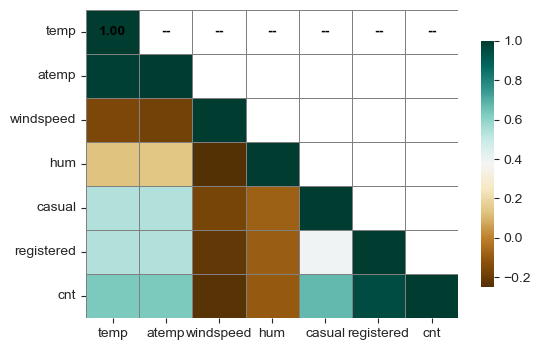

            temp  atemp  windspeed   hum  casual  registered   cnt
temp        1.00   0.99      -0.16  0.13    0.54        0.54  0.63
atemp       0.99   1.00      -0.18  0.14    0.54        0.54  0.63
windspeed  -0.16  -0.18       1.00 -0.25   -0.17       -0.22 -0.24
hum         0.13   0.14      -0.25  1.00   -0.08       -0.09 -0.10
casual      0.54   0.54      -0.17 -0.08    1.00        0.39  0.67
registered  0.54   0.54      -0.22 -0.09    0.39        1.00  0.95
cnt         0.63   0.63      -0.24 -0.10    0.67        0.95  1.00


In [746]:
%matplotlib inline
corr_matrix=data_df[features_continous_var].corr().round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

plt.figure(figsize = (6,4))
sns.heatmap(corr_matrix,mask=mask, annot=True, fmt=".2f", cmap='BrBG',
            cbar_kws={'shrink': 0.8}, linewidths=0.5, linecolor='grey',
            annot_kws={'size': 10, 'weight': 'bold', 'color': 'black'})
plt.show()
print(corr_matrix)

#### **Observations**
- ##### *Multicollinearity relationship between the features are found*
- ##### ***temp** and **atemp** are strongly correlated posively hence one of them can be ignored*
- ##### ***registered** and **casual** are strongly and moderately correlated respectively wrt to **cnt** and since these data is only available after the end user rents the bike hence both of them can be ignored*

In [748]:
data=data_df
data_df = data_df.drop(['atemp','casual','registered'],axis =1)

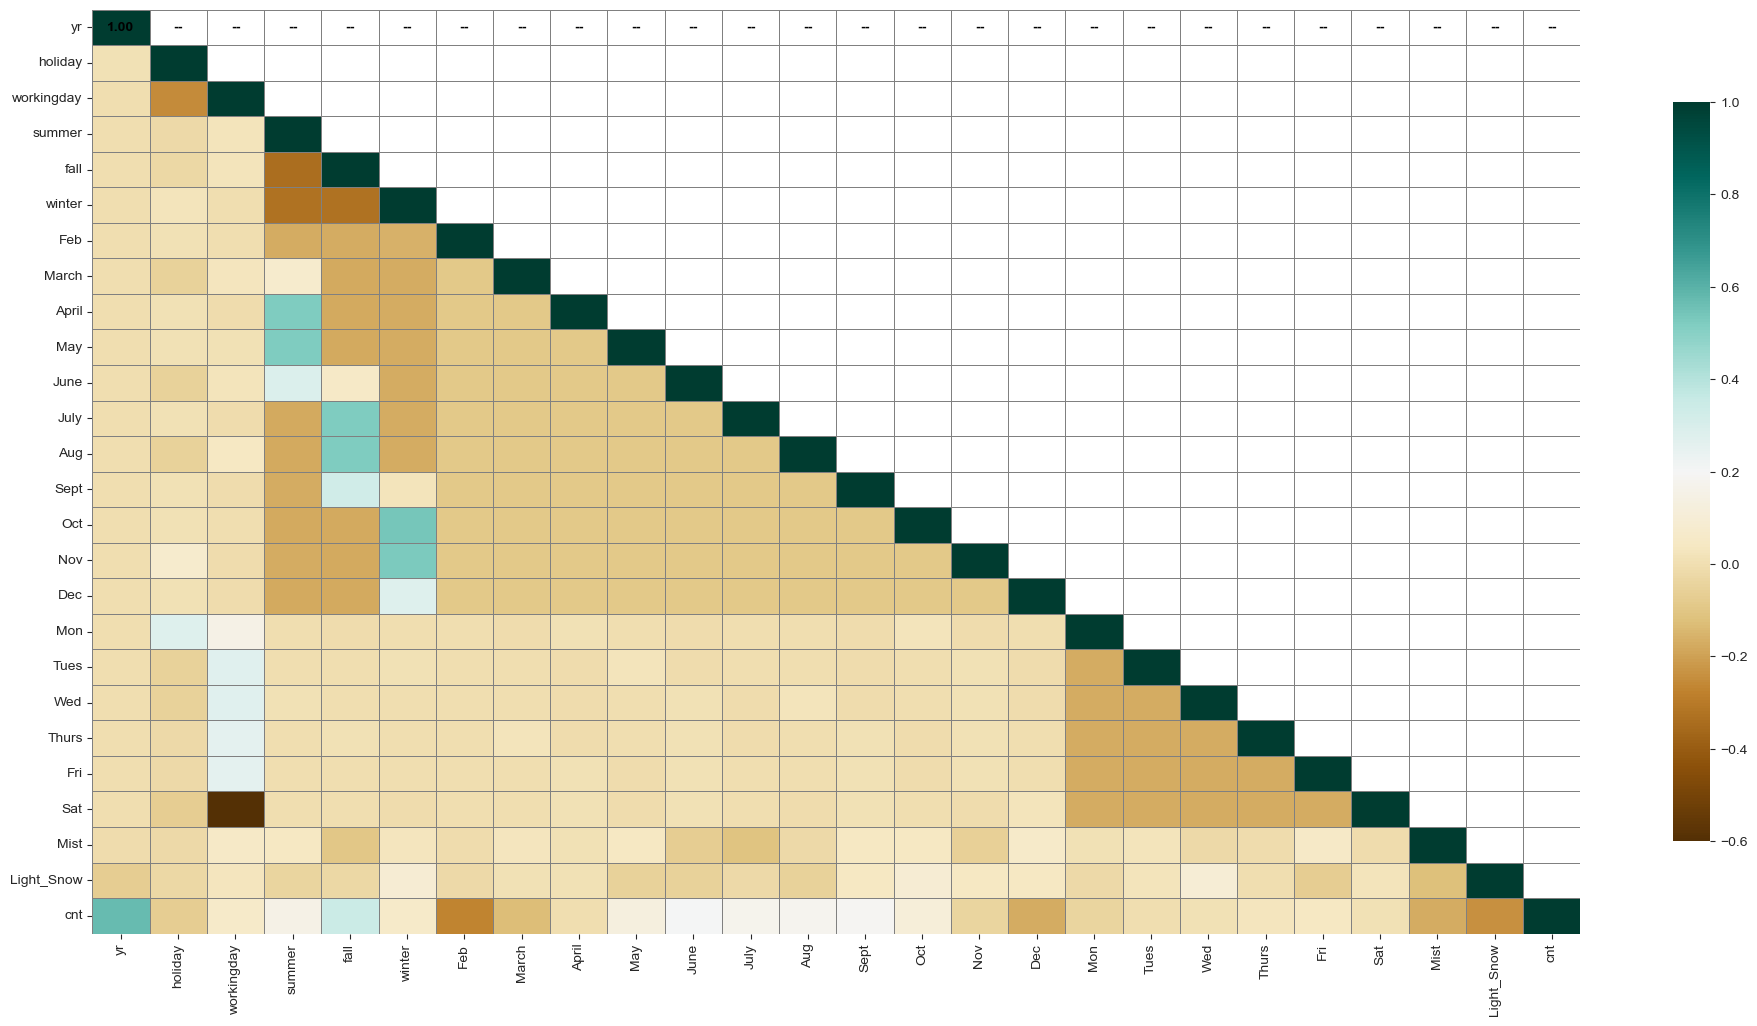

              yr  holiday  workingday  summer  fall  winter   Feb  March  \
yr          1.00     0.01       -0.00   -0.00  0.00   -0.00 -0.00   0.00   
holiday     0.01     1.00       -0.25   -0.02 -0.03    0.02  0.01  -0.05   
workingday -0.00    -0.25        1.00    0.02  0.02   -0.00 -0.00   0.03   
summer     -0.00    -0.02        0.02    1.00 -0.34   -0.33 -0.17   0.07   
fall        0.00    -0.03        0.02   -0.34  1.00   -0.33 -0.17  -0.18   
winter     -0.00     0.02       -0.00   -0.33 -0.33    1.00 -0.16  -0.17   
Feb        -0.00     0.01       -0.00   -0.17 -0.17   -0.16  1.00  -0.09   
March       0.00    -0.05        0.03    0.07 -0.18   -0.17 -0.09   1.00   
April      -0.00     0.01       -0.01    0.52 -0.18   -0.17 -0.09  -0.09   
May         0.00     0.01        0.01    0.52 -0.18   -0.17 -0.09  -0.09   
June       -0.00    -0.05        0.02    0.29  0.05   -0.17 -0.09  -0.09   
July        0.00     0.01       -0.01   -0.18  0.52   -0.17 -0.09  -0.09   
Aug         

In [749]:
#data_df[data_df.columns.difference(features_continous_var)]
#data_df[data_df.columns[~data_df.columns.isin(features_continous_var)]]
data_df_bool=data_df[data_df.columns[~data_df.columns.isin(features_continous_var)].tolist() + ['cnt']]
#print(data_df_bool)
corr_matrix=data_df_bool.corr().round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
plt.figure(figsize = (24,12))
sns.heatmap(corr_matrix,mask=mask, annot=True, fmt=".2f", cmap='BrBG',
            cbar_kws={'shrink': 0.8}, linewidths=0.5, linecolor='grey',
            annot_kws={'size': 10, 'weight': 'bold', 'color': 'black'})
plt.show()
print(corr_matrix)


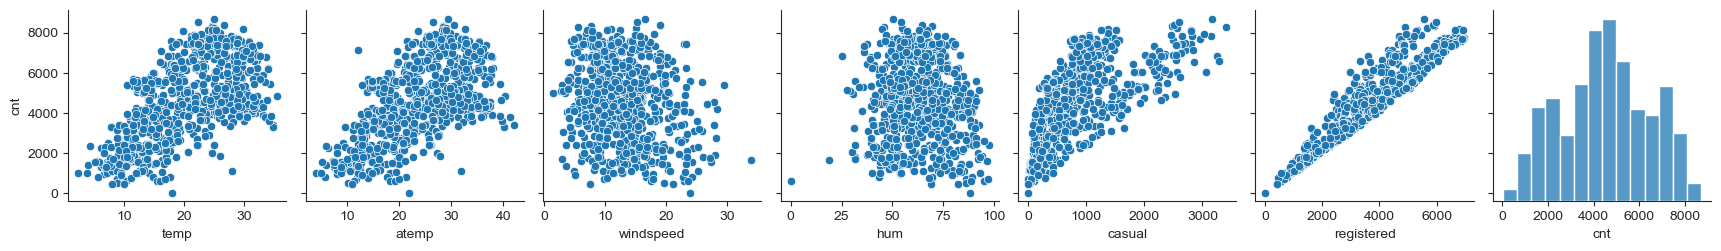

In [750]:
# Plotting continous independent variables / features against target variable ie cnt
sns.pairplot(data, x_vars=features_continous_var,y_vars=['cnt'])
plt.show()

['yr', 'holiday', 'workingday', 'summer', 'fall', 'winter', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Mist', 'Light_Snow']


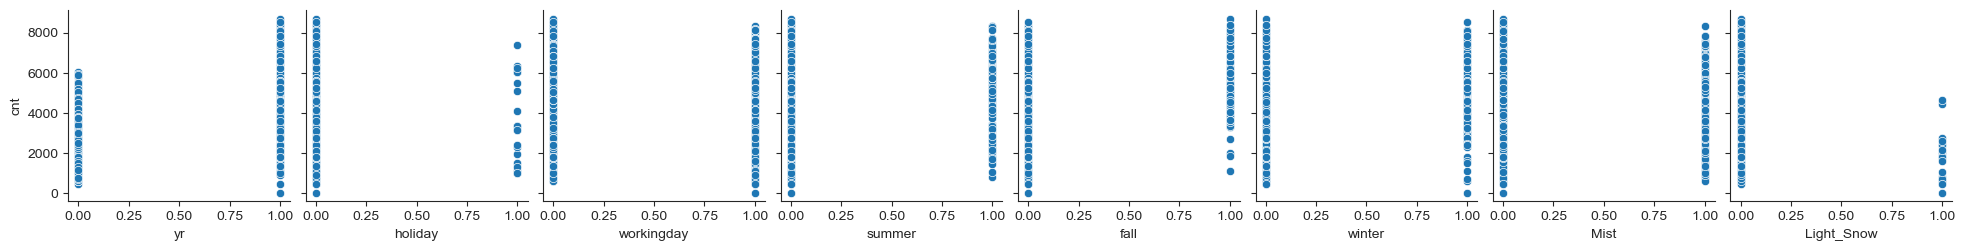

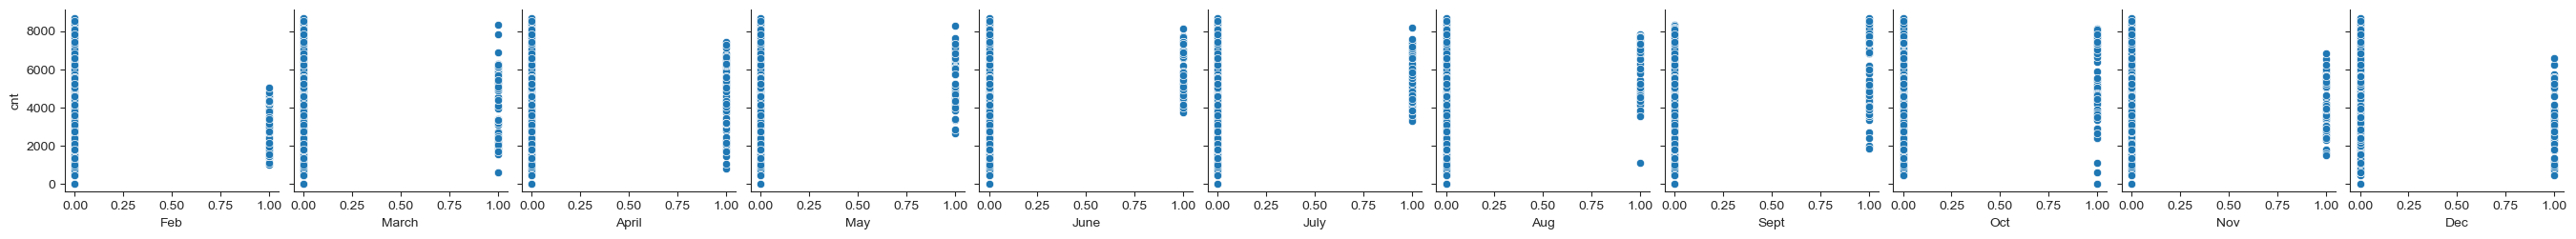

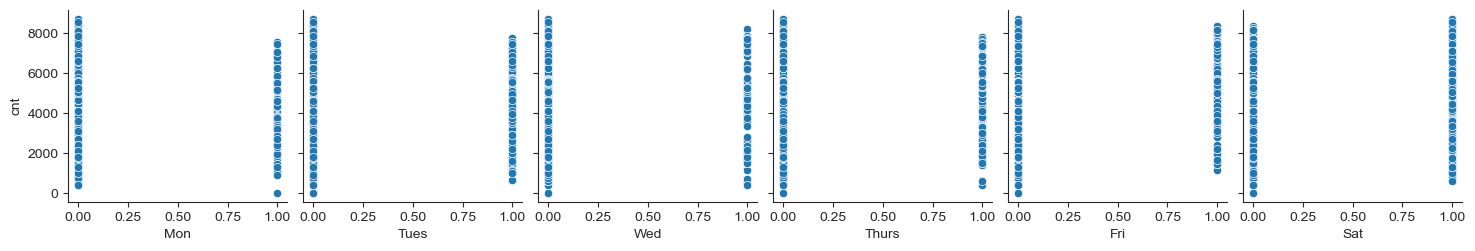

In [751]:
# Plotting binary independent variables / features against target variable ie cnt
print(data_df.columns[~data_df.columns.isin(features_continous_var)].tolist())
sns.pairplot(data, x_vars=['yr', 'holiday', 'workingday', 'summer', 'fall', 'winter','Mist', 'Light_Snow'],y_vars=['cnt'])
plt.show()
sns.pairplot(data, x_vars=['Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],y_vars=['cnt'])
plt.show()
sns.pairplot(data, x_vars=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'],y_vars=['cnt'])
plt.show()

#### **Observations**
- ##### *More bikes were rented in 2019 compared to 2018,shows us the growth of the business is in uptrend*
- ##### *The majority of bike rentals occur on weekdays.*
- ##### *Users prefer to rent bikes when the weather is clear without Light Snow.*
- ##### *Registered bike users outnumber casual users and show a strong correlation with the target variable.*
- ##### *BOOM Bikes can anticipate higher demand for rentals during the winter season.*
- ##### *Bike rentals are lowest on holidays.*


### *2.Data Modelling*


In [754]:
# Splitting the data into training and testing data sets
df_train,df_test = train_test_split(data_df,train_size=0.7,random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 29)
(220, 29)


In [755]:
# Scaling the data to ensure uniformity in the range of values during regression
scaler = MinMaxScaler()

# Creating  list of Continous Independent Variables which need to Scaled
num_vars = ['temp', 'windspeed','hum','cnt']

# For the Training Data Fit and Transform both need to done.
df_train[num_vars]=scaler.fit_transform(df_train[num_vars])

# View the Statistical Description to ensure MinMax Scaling has done properly
df_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,summer,fall,winter,...,Nov,Dec,Mon,Tues,Wed,Thurs,Fri,Sat,Mist,Light_Snow
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.650480,0.320883,0.513499,0.247059,0.262745,0.247059,...,0.086275,0.084314,0.150980,0.131373,0.158824,0.133333,0.127451,0.154902,0.345098,0.029412
std,0.500429,0.157763,0.468282,0.225858,0.145846,0.169803,0.224421,0.431725,0.440557,0.431725,...,0.281045,0.278131,0.358381,0.338139,0.365870,0.340268,0.333805,0.362166,0.475867,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.754830,0.414447,0.684710,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [756]:
# Preparation of Training Dataset
y_train = df_train.pop('cnt')
X_train = df_train
print(X_train.shape)
y_train.sample(5)

(510, 28)


361    0.262310
592    0.872411
177    0.539116
70     0.242752
303    0.419581
Name: cnt, dtype: float64

#### *RFE(Recursive Feature Elimination)*

In [758]:
# Running RFE with the Output Number of variables equals to 20
lm = LinearRegression()
lm.fit(X_train,y_train)
# Running RFE
rfe = RFE(estimator=lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [759]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('summer', True, 1),
 ('fall', True, 1),
 ('winter', True, 1),
 ('Feb', False, 6),
 ('March', False, 2),
 ('April', False, 4),
 ('May', False, 3),
 ('June', False, 5),
 ('July', False, 7),
 ('Aug', True, 1),
 ('Sept', True, 1),
 ('Oct', True, 1),
 ('Nov', False, 8),
 ('Dec', False, 9),
 ('Mon', False, 10),
 ('Tues', False, 11),
 ('Wed', False, 13),
 ('Thurs', False, 14),
 ('Fri', False, 12),
 ('Sat', True, 1),
 ('Mist', True, 1),
 ('Light_Snow', True, 1)]

In [760]:
# RFE Selected Features
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'summer',
       'fall', 'winter', 'Aug', 'Sept', 'Oct', 'Sat', 'Mist', 'Light_Snow'],
      dtype='object')

In [761]:
# Features Rejected by the RFE
X_train.columns[~(rfe.support_)]

Index(['Feb', 'March', 'April', 'May', 'June', 'July', 'Nov', 'Dec', 'Mon',
       'Tues', 'Wed', 'Thurs', 'Fri'],
      dtype='object')

***Model using statsmodels for the detailed statistics***

In [763]:
# Creating X train with RFE Selected Variables
X_train_rfe = X_train[col]

In [764]:
# Adding Constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Create Object for the Model
lm = sm.OLS(y_train, X_train_rfe).fit()

# View Summary of Statistics
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     183.9
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          5.17e-191
Time:                        23:49:19   Log-Likelihood:                 519.44
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1952      0.029      6.790      0.000       0.139       0.252
yr             0.2301      0.008     28.743      0.000       0.214       0.246
holiday       -0.0545      0.027     -2.025      0.043      -0.107      -0.002
workingday     0.0445      0.012      3.856      0.000       0.022       0.067
temp           0.4972      0.034     14.821      0.000       0.431       0.563
hum           -0.1639      0.037     -4.395      0.000      -0.237      -0.091
windspeed     -0.1825      0.025     -7.196      0.000      -0.232      -0.133
summer         0.1183      0.015      8.038      0.000       0.089       0.147
fall           0.0292      0.022      1.329      0.184      -0.014       0.072
winter         0.1430      0.013     10.671      0.000       0.117       0.169
Aug            0.0473      0.017      2.732      0.007       0.013       0.081
Sept           0.1176      0.017      6.876      0.000       0.084       0.151
Oct            0.0416      0.017      2.391      0.017       0.007       0.076
Sat            0.0531      0.015      3.655      0.000       0.025       0.082
Mist          -0.0577      0.010     -5.564      0.000      -0.078      -0.037
Light_Snow    -0.2507      0.026     -9.579      0.000      -0.302      -0.199
==============================================================================
Omnibus:                       76.225   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.955
Skew:                          -0.743   Prob(JB):                     1.40e-44
Kurtosis:                       5.701   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [765]:
# Calculation of VIF
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values,i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,const,53.48
8,fall,6.04
4,temp,3.71
7,summer,2.61
9,winter,2.16
5,hum,1.91
3,workingday,1.88
13,Sat,1.79
10,Aug,1.68
14,Mist,1.57


#### **Observations**
- ##### *We achieved a strong Adjusted R² score of 84.3%.*
- ##### *The Prob(F-statistic) is very low, indicating that the overall model is a good fit.*
- ##### *All the p-values are below 0.043, indicating that all 14 features are statistically significant.*
- ##### *Therefore, we can proceed with this model for prediction and evaluation.*

### *3.Residual Analysis*

In [768]:
# Calculation of Error in Training Data
y_train_pred = lm.predict(X_train_rfe)
res = (y_train - y_train_pred)

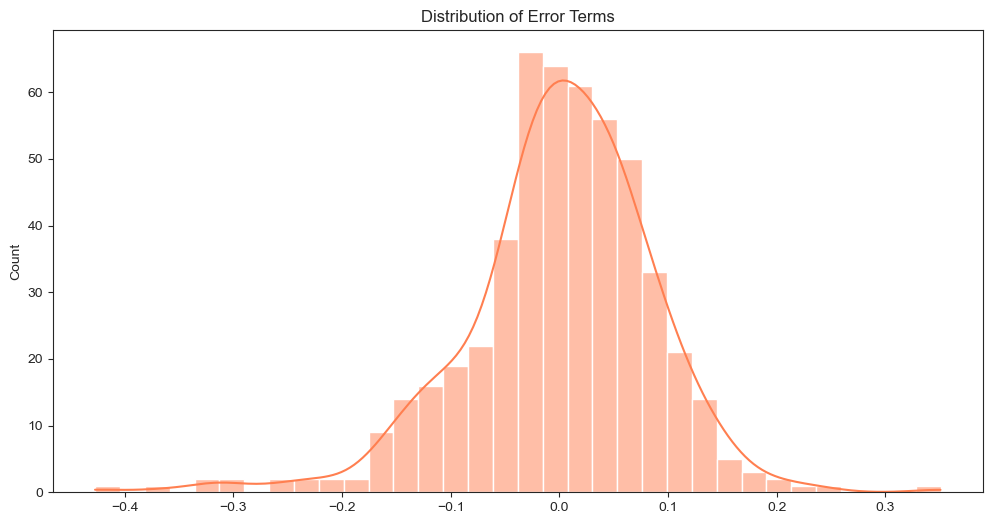

In [769]:
# Set the style of the plot
sns.set_style("ticks")
plt.figure(figsize=(12, 6))
sns.histplot(res, kde=True, color='coral')  
plt.title('Distribution of Error Terms')
plt.show()

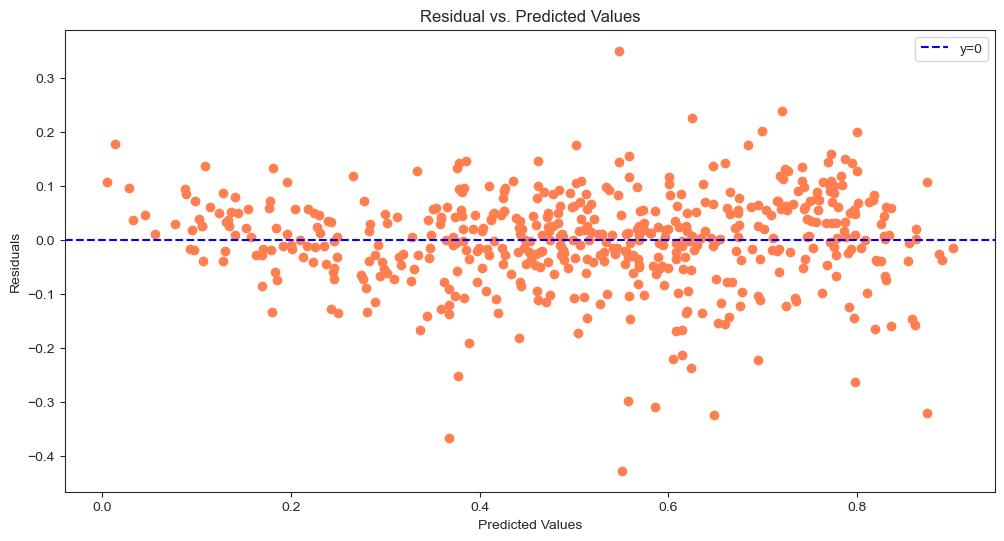

In [770]:
sns.set_style("ticks")
plt.figure(figsize=(12, 6))

# Scatter plot of residuals vs. predicted values
plt.scatter(y_train_pred, res, color='coral')

# Adding a horizontal line at y=0
plt.axhline(y=0, color='blue', linestyle='--', linewidth=1.5, label='y=0')

plt.title('Residual vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

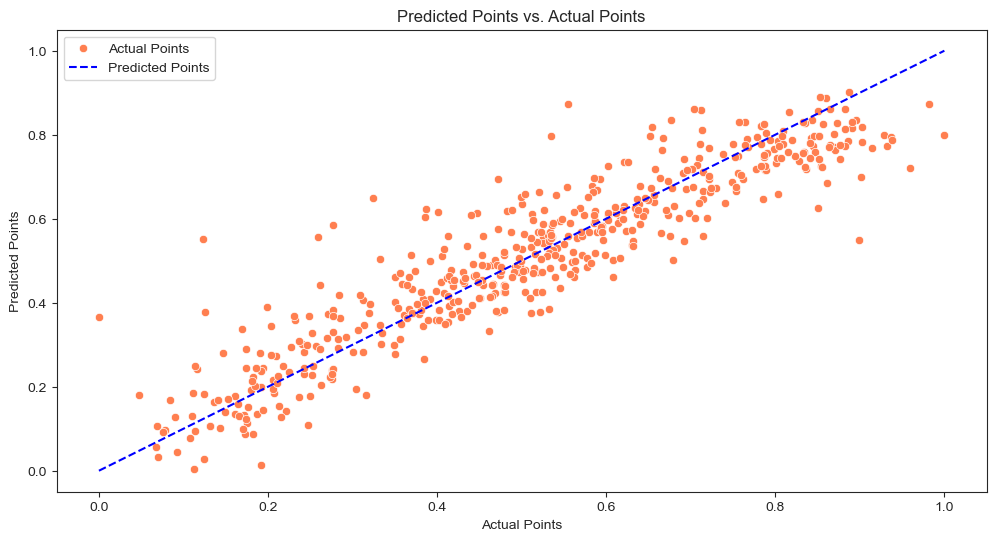

In [771]:
sns.set_style("ticks")
plt.figure(figsize=(12, 6))

sns.scatterplot(x=y_train, y=y_train_pred, color='coral', label='Actual Points')

sns.lineplot(x=y_train, y=y_train, color='blue', linestyle='--', label='Predicted Points')

plt.title('Predicted Points vs. Actual Points')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.legend()
plt.show()


#### **Observations**
- ##### *The error terms appear to be normally distributed with a mean of zero, indicating that the model satisfies the normality assumption..*
- ##### *No specific pattern is observed in the error terms relative to the predictions, suggesting that the error terms are independent of one another.*
- ##### *The error terms exhibit approximately constant variance, indicating that the assumption of homoscedasticity is satisfied.*



### *4.Model Evaluation on Test Dataset*

In [774]:
#Applying the MinMax scaling on the test sets
num_vars = ['temp', 'windspeed',"hum",'cnt']

df_test[num_vars]=scaler.transform(df_test[num_vars])

y_test = df_test.pop('cnt')
X_test = df_test
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,yr,holiday,workingday,temp,hum,windspeed,summer,fall,winter,...,Nov,Dec,Mon,Tues,Wed,Thurs,Fri,Sat,Mist,Light_Snow
184,1.0,0,1,0,0.831783,0.657364,0.084219,0,1,0,...,0,0,1,0,0,0,0,0,1,0
535,1.0,1,0,1,0.901354,0.610133,0.153728,1,0,0,...,0,0,0,0,1,0,0,0,0,0
299,1.0,0,0,1,0.511964,0.837699,0.334206,0,0,1,...,0,0,0,0,0,1,0,0,1,0
221,1.0,0,0,1,0.881625,0.437098,0.339570,0,1,0,...,0,0,0,0,1,0,0,0,0,0
152,1.0,0,0,1,0.817246,0.314298,0.537414,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [775]:
#Dropping the Features which were eliminated during the Training Process
X_test_sm = X_test_sm.drop([ 'Feb', 'March', 'April', 'May', 'June', 'July', 'Nov', 'Dec', \
       'Mon', 'Tues', 'Wed', 'Thurs', 'Fri'],axis=1)

# Predict the Price for Test Data using the Trainned Model
y_test_pred = lm.predict(X_test_sm)

y_test_pred.sample(5)

721    0.418364
682    0.600378
546    0.786201
218    0.505423
411    0.425258
dtype: float64

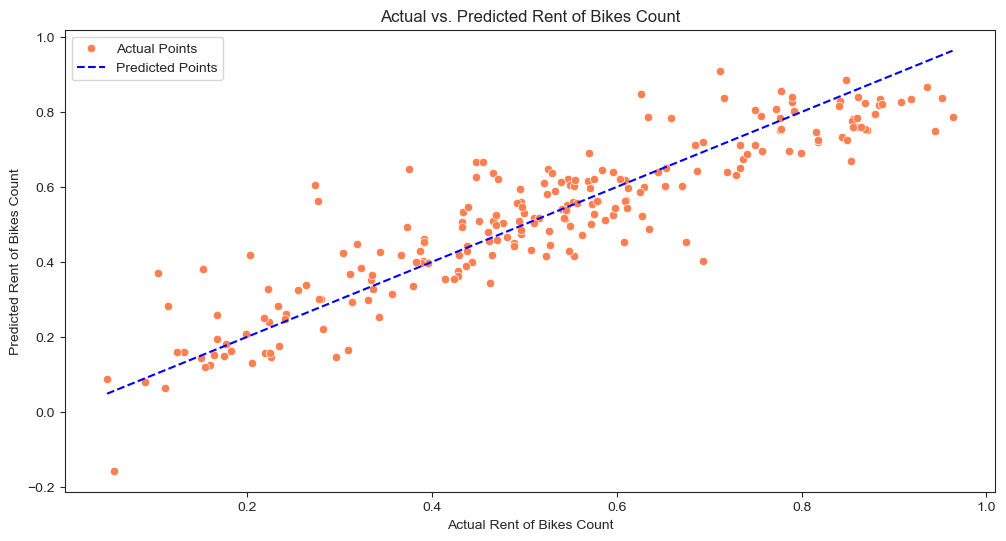

In [776]:
# Plotting y_test and y_pred to understand the spread.
sns.set_style("ticks")
plt.figure(figsize=(12, 6))

sns.scatterplot(x=y_test, y=y_test_pred, color='coral', label='Actual Points')

sns.lineplot(x=y_test, y=y_test, color='blue', linestyle='--', label='Predicted Points')

plt.title('Actual vs. Predicted Rent of Bikes Count')
plt.xlabel('Actual Rent of Bikes Count')
plt.ylabel('Predicted Rent of Bikes Count')
plt.show()

In [777]:
# R2 Scores of the Training Model
r2_score(y_train,y_train_pred)

0.8480875210274799

In [778]:
# Checking the Accuracy of the Test Model
r2_score(y_test,y_test_pred)

0.820797708367554

#### **Observations**
- ##### *The scatter plot above illustrates the linear relationship between the actual and predicted counts of bike rentals on test data.*
- ##### *The model accuracy of Test Data is 82.07% ,which means its a good score.*
- ##### *The accuracy difference between the training and test data is around 2%, which is considered acceptable.*

In [780]:
Cofficients = round(lm.params,2)
beta = Cofficients.sort_values(ascending = False)
beta

temp          0.50
yr            0.23
const         0.20
winter        0.14
summer        0.12
Sept          0.12
Aug           0.05
Sat           0.05
workingday    0.04
Oct           0.04
fall          0.03
holiday      -0.05
Mist         -0.06
hum          -0.16
windspeed    -0.18
Light_Snow   -0.25
dtype: float64

In [781]:
for i in range(0, len(beta)):
    print(beta[i],'*',beta.index[i],end ='')
    print(' + ',end ='')

0.5 * temp + 0.23 * yr + 0.2 * const + 0.14 * winter + 0.12 * summer + 0.12 * Sept + 0.05 * Aug + 0.05 * Sat + 0.04 * workingday + 0.04 * Oct + 0.03 * fall + -0.05 * holiday + -0.06 * Mist + -0.16 * hum + -0.18 * windspeed + -0.25 * Light_Snow + 

#### **Observations and Final Conclusion**
- ##### *Considering multiple features/variable and hence by perfoming **Multiple** Variable **Linear Regression**,the best fit line equation can be*
  y=0.2(const) + 0.5 * temp + 0.23 * yr + 0.2 * const + 0.14 * winter + 0.12 * summer + 0.12 * Sept + 0.05 * Aug + 0.05 * Sat + 0.04 *  workingday + 0.04 * Oct + 0.03 * fall + -0.05 * holiday + -0.06 * Mist + -0.16 * hum + -0.18 * windspeed + -0.25 * Light_Snow

- ##### *Temperature is the most significant factor positively impacting the business.*
- ##### *Environmental conditions such as rain, humidity, windspeed, and cloudiness have a negative effect on the business*
- ##### *The company should address adverse weather conditions by developing solutions to protect users from rain.*
- ##### *Bike demand peaks during winter and summer, with users generally avoiding bike rentals on rainy days or during rainy seasons.*
- ##### *Bike rentals are notably higher on Saturdays compared to other days of the week.*
- ##### *Bike rental demand in 2019 has significantly increased compared to 2018, indicating strong growth for Boom Bikes.*